# ofblockmeshdicthelper. Meshing simple geometry for an orifice plate
***

`ofblockmeshdicthelper` is a python library made by Takkaki Aoki, which can be downloaded from [github](https://github.com/takaakiaoki/ofblockmeshdicthelper.git) but, can be also very easily installed with

    pip install ofblockmeshdicthelper
    
Or it can also downloaded from GitHub and installed (it will be then the latest version)

Were are going to explore the pressure loss in an orifice plate. The real value is defined by the [ISO 5167](https://en.wikipedia.org/wiki/Orifice_plate), and the results from the simulation can be compared. The simulation will be done with a laminar steady (simpleFoam) axysimmetric simulation.

First we import the needed modules

In [19]:
import numpy as np
from ofblockmeshdicthelper import *

Now we define the geometry and the discretization

In [20]:
wedgeangle = 5
r = 10
ro = 5
l1 = 70
lo = 2.5
l2 = 50
deltax = 0.25
deltay = 0.25
Nx1 = np.int(l1/deltax)
Nx2 = np.int(lo/deltax)
Nx3 = np.int(l2/deltax)
Ny1 = np.int(ro/deltay)
Ny2 = np.int((r-ro)/deltay)

Here an object of class `BlockMeshDict` is created (note that you can create many dictionaries

In [21]:
bmd = BlockMeshDict()

Define the scale (geometry has been typed in mm)

In [22]:
bmd.set_metric('mm')

Define the base vertex (there will be etruded to create the wedge)

In [23]:
basevs = [
    Vertex(0,0,0,'v0'),
    Vertex(l1,0,0,'v1'),
    Vertex(l1+lo,0,0,'v2'),
    Vertex(l1+lo+l2,0,0,'v3'),
    Vertex(l1+lo+l2,ro,0,'v4'),
    Vertex(l1+lo+l2,r,0,'v5'),
    Vertex(l1+lo,r,0,'v6'),
    Vertex(l1+lo,ro,0,'v7'),
    Vertex(l1,ro,0,'v8'),
    Vertex(l1,r,0,'v9'),
    Vertex(0,r,0,'v10'),
    Vertex(0,ro,0,'v11'),
]

The next blocks are only to plot the geometry just to see how it looks like.

In [25]:
x=[]
y=[]
for v in basevs:
    x.append(v.x)
    y.append(v.y)

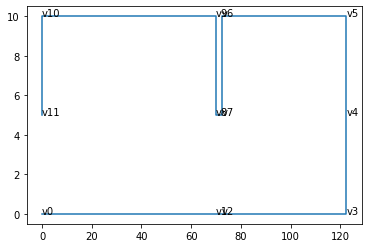

In [26]:
import matplotlib.pyplot as plt
plt.plot(x,y)
for v in basevs:
    plt.annotate(v.name,(v.x,v.y))

The extruded wedges are calculated and included in the dictionary

In [27]:
cosd = np.cos(np.radians(wedgeangle))
sind = np.sin(np.radians(wedgeangle))
for v in basevs:
    bmd.add_vertex(v.x, v.y*cosd, v.y*sind, v.name+'+z')
    bmd.add_vertex(v.x, v.y*cosd, -v.y*sind, v.name+'-z')

Some of the vertexs are duplicated and then they can be "collapsed" in only one

In [28]:
bmd.reduce_vertex('v0-z','v0+z')
bmd.reduce_vertex('v1-z','v1+z')
bmd.reduce_vertex('v2-z','v2+z')
bmd.reduce_vertex('v3-z','v3+z')

For blocks generation

In [30]:
def vnamegen(x0y0, x1y0, x1y1, x0y1):
    return (x0y0+'-z', x1y0+'-z', x1y1+'-z', x0y1+'-z',
            x0y0+'+z', x1y0+'+z', x1y1+'+z', x0y1+'+z')

In [31]:
b0 = bmd.add_hexblock(vnamegen('v0', 'v1', 'v8', 'v11'),
                      (Nx1, Ny1, 1),
                      'b0',
                      grading=SimpleGrading(1,1,1))

In [32]:
b1 = bmd.add_hexblock(vnamegen('v11', 'v8', 'v9', 'v10'),
                      (Nx1, Ny2, 1),
                      'b1',
                      grading=SimpleGrading(1,1,1))

In [33]:
b2 = bmd.add_hexblock(vnamegen('v1', 'v2', 'v7', 'v8'),
                      (Nx2, Ny1, 1),
                      'b2',
                      grading=SimpleGrading(1,1,1))

In [34]:
b3 = bmd.add_hexblock(vnamegen('v2', 'v3', 'v4', 'v7'),
                      (Nx3, Ny1, 1),
                      'b3',
                      grading=SimpleGrading(1,1,1))

In [37]:
b4 = bmd.add_hexblock(vnamegen('v7', 'v4', 'v5', 'v6'),
                      (Nx3, Ny2, 1),
                      'b4',
                      grading=SimpleGrading(1,1,1))

For boundaries generation

In [39]:
bmd.add_boundary('wedge', 'front',
                 [
                     b0.face('t'),
                     b1.face('t'),
                     b2.face('t'),
                     b3.face('t'),
                     b4.face('t'),
                 ]
                )
bmd.add_boundary('wedge', 'back', 
                 [
                     b0.face('b'),
                     b1.face('b'),
                     b2.face('b'),
                     b3.face('b'),
                     b4.face('b'),
                 ]
                )
bmd.add_boundary('wall', 'wall', 
                 [
                     b1.face('n'),
                     b1.face('e'),
                     b2.face('n'),
                     b4.face('w'),
                     b4.face('n'),
                 ]
                )
bmd.add_boundary('patch', 'inlet', 
                 [
                     b0.face('w'),
                     b1.face('w'),
                 ]
                )
bmd.add_boundary('patch', 'outlet', 
                 [
                     b3.face('e'),
                     b4.face('e'),
                 ]
                )
bmd.add_boundary('empty', 'axis', 
                 [
                     b0.face('s'),
                     b2.face('s'),
                     b3.face('s'),
                 ]
                )

Vertex are labelled

In [40]:
bmd.assign_vertexid()

And finally the dictionary is printed and saved to a file

In [18]:
print(bmd.format())
print(bmd.format(),file=open('./blockMeshDict','w'))

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  2.3.0                                 |
|   \\  /    A nd           | Web:      www.OpenFOAM.org                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      blockMeshDict;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

convertToMeters 0.001;

vertices
(
    (                  0   9.96194698091746 -0.871557427476582 )  // 0 v10-z
    (                 70   9.96194698091746 -0.871557427476582 )  // 1 v9-z
    (               72.5   9.96194698091746 -0.87155742